# MountainCar DQN

In [38]:
import math
import copy
import time
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class MemoryBuffer:
    """ 
    Overwrite memory for storing the environment model.
    This implementation is not the most efficient, but it is needed for experimenting with sorting.
    """
    def __init__(self, capacity, n_states, n_actions):
        """
        capacity  - memory capacity (maximum number of stored items)
        n_states  - number of state variables
        n_actions - number of actions
        """
        self.capacity = capacity    # maximum number of stored elements
        self.count = 0              # how many items have already been saved
        self.index = 0              # index of element to be inserted
        self.nS = n_states
        self.nA = n_actions

        self.memo = np.zeros( (capacity, self.nS*2 + 4), dtype = np.float32)

    #------------------------------------------------------------------------------------        
    
    def add(self, s0, a0, s1, r1, done):
        """ Add example to memory """
        self.index = self.index % self.capacity
        
        norm = np.dot(s1,s1)**0.5  
        self.memo[self.index] = np.concatenate(( s0, s1, [a0], [r1], [1.-done], [norm]) )

        self.index += 1
        self.count += 1

        #if self.count == self.capacity or (self.count > self.capacity and self.index >= self.capacity // 2):
        #    self.memo = self.memo[self.memo[:, -1].argsort() ]  # [::-1]
        #    self.index = 0
        
    #------------------------------------------------------------------------------------
        
    def samples(self, count):
        """ Return count of random examples from memory """
        mem_max = min(self.count, self.capacity)
        indxs = np.random.choice(mem_max, count, replace=False)
        sample = self.memo[indxs]
        s0 = sample[:, 0:           self.nS]
        s1 = sample[:, self.nS:     2*self.nS]
        a0 = sample[:, 2*self.nS:   2*self.nS+1]
        r1 = sample[:, 2*self.nS+1: 2*self.nS+2]
        dn = sample[:, 2*self.nS+2: 2*self.nS+3]
        return torch.tensor(s0), torch.tensor(a0, dtype = torch.int64), torch.tensor(s1), torch.tensor(r1), torch.tensor(dn)

    #------------------------------------------------------------------------------------
    
    def plot(self, text, history, params):
        """ Plot histogram for states and actions """
        num = min(self.count, self.capacity)
        if num == 0:
            return

        fig, ax = plt.subplots(1, 3, figsize=(16,6), gridspec_kw={'width_ratios': [2, 1, 5]})        
        plt.suptitle(text, fontsize=18)
        
        bins = np.linspace(0, math.sqrt(self.nS), 101)
        s1 = self.memo[:num, self.nS: 2*self.nS]
        hist, bins = np.histogram(s1, bins=bins, density=True)
        ax[0].set_xlim(min(bins), max(bins))
        ax[0].grid(axis='x', alpha=0.75); ax[0].grid(axis='y', alpha=0.75)
        ax[0].set_xlabel('|s1|', fontsize=16)
        bins = [ (bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]        
        ax[0].bar(bins, hist, width=0.5, color='blue')
                
        bins = np.linspace(-0.5, self.nA-0.5, self.nA+1)        
        a = self.memo[:num, 2*self.nS: 2*self.nS+1],
        hist, bins = np.histogram(a, bins=bins, density=True)
        ax[1].set_xlim(min(bins), max(bins))
        ax[1].grid(axis='x', alpha=0.75); ax[1].grid(axis='y', alpha=0.75)
        ax[1].set_xlabel('actions', fontsize=16)
        ax[1].set_xticks(np.arange(self.nA));
        bins = [ (bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]        
        ax[1].bar(bins, hist, width=0.5, color='blue')

        ax[2].plot(history[:,0], history[:,1], linewidth=1)
        ax[2].set_ylim(-200, -80);
        ax[2].set_xlabel('episode', fontsize=16)        
        ax[2].grid(axis='x', alpha=0.75); ax[2].grid(axis='y', alpha=0.75)
        params = [ f"{k:9s}: {v}\n" for k,v in params.items()]
        ax[2].text(100, -200, "".join(params), {'fontsize':12, 'fontname':'monospace'})

        plt.show()

#========================================================================================

class DQN:
    """ DQN метод для дискретных действий """
    def __init__(self, env):
        self.env     = env                         # environment we work with
        self.obs_min = env.observation_space.low   # minimum observation values
        self.obs_max = env.observation_space.high  # maximum observation values
        self.nA      =  self.env.action_space.n    # number of discrete actions
        self.nS      =  self.env.observation_space.shape[0] # number of state components

        self.params = {           # default parameters
            'method'   : "DQN",     # kind of the method (DQN, DDQN)     
            'gamma'    : 0.99,      # discount factor
            'eps1'     : 1.0,       # initial value epsilon
            'eps2'     : 0.001,     # final value   epsilon
            'decays'   : 1000,      # number of episodes to decay eps1 - > eps2
            'update'   : 10,        # target model update rate (in frames = time steps)         
            'batch'    : 100,       # batch size for training
            'capacity' : 100000,    # memory size
            'hiddens'  : [256,128], # hidden layers
            'scale'    : True,      # scale or not observe to [-1...1]
            'optimizer': 'sgd',     # optimizer (sgd, adam)
            'lm'       : 0.001,     # learning rate           
        }
        self.last_loss = 0.       # last loss
        self.history = []

        print("obs_min:   ", self.obs_min)
        print("obs_max:   ", self.obs_max)
        print("obs_shape: ", self.obs_max)
        
    #------------------------------------------------------------------------------------

    def get_model(self, hiddens):
        """ Create a neural network """

        neurons = [self.nS] + hiddens + [self.nA]
        layers  = []
        for i in range(len(neurons)-1):
            layers.append(nn.Linear(neurons[i], neurons[i+1]) )
            if i < len(neurons)-2:
                layers.append( nn.ReLU() )
        
        return nn.Sequential(*layers)

    #------------------------------------------------------------------------------------

    def init(self):
        """ Create a neural network and optimizer """

        self.gpu =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("device:", self.gpu)

        self.model  = self.get_model(self.params['hiddens']).to(self.gpu)      # current Q
        self.target = self.get_model(self.params['hiddens']).to(self.gpu)      # target  Q

        self.best_model  = self.get_model(self.params['hiddens']).to(self.gpu) # best net
        self.best_reward = -100000                                             # best reward

        self.loss      = nn.MSELoss()
        if   self.params['optimizer'] == 'sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.params['lm'], momentum=0.8)
        elif self.params['optimizer'] == 'adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.params['lm'])
        else:
            print("ERROR: Unknown optimizer!!!")

        self.memo = MemoryBuffer(self.params['capacity'], self.nS, self.nA)        
        
        self.epsilon     = self.params['eps1']        # start value in epsilon greedy strategy
        self.decay_rate  = math.exp(math.log(self.params['eps2']/self.params['eps1'])/self.params['decays'])

        print(f"decay_rate: {self.decay_rate:.4f}")
        print(self.model)        

    #------------------------------------------------------------------------------------

    def copy_model(self, model):
        model.load_state_dict( self.model.state_dict() )

    #------------------------------------------------------------------------------------

    def scale(self, obs):
        """ to [-1...1] """
        if self.params['scale']:
            return -1. + 2.*(obs - self.obs_min)/(self.obs_max-self.obs_min)
        else:
            return obs
    #------------------------------------------------------------------------------------

    def policy(self, state):
        """ Return action according to epsilon greedy strategy """
        if np.random.random() < self.epsilon:
            #return 2*int(state[1] > 0)
            return np.random.randint(self.nA)    # random action

        x = torch.tensor(state, dtype=torch.float32).to(self.gpu)
        with torch.no_grad():
            y = self.model(x).detach().to('cpu').numpy() 
        return np.argmax(y)                      # best action

    #------------------------------------------------------------------------------------

    def run_episode(self, ticks = 200):
        """ Run one episode, keeping the environment model in memory """
        rew = 0                                  # total reward
        s0 = self.env.reset()                    # initial state
        s0 = self.scale (s0)                     # scale it
        a0 = self.policy(s0)                     # get action
        for t in range(ticks):
            s1, r1, done, _ = self.env.step(a0)
            s1 = self.scale (s1)
            a1 = self.policy(s1)

            self.memo.add(s0, a0, s1, r1, float(done and t < ticks) )            

            if self.frame % self.params['update'] == 0:
                self.copy_model(self.target)

            if self.memo.count >= self.params['batch']:    
                self.learn_model()                         

            rew += r1
            self.frame += 1

            if done:
                break

            s0, a0 = s1, a1
        return rew

    #------------------------------------------------------------------------------------

    def learn(self, episodes = 100000, ticks = 200, stat = 100, plots = 1000, env_name = ""):
        """ Repeat episodes episodes times """
        self.frame = 1
        rews, mean, beg   = [], 0, time.process_time()
        for episode in range(1, episodes+1):
            rew = self.run_episode(ticks)
            rews.append( rew )

            self.epsilon *= self.decay_rate                # epsilon-decay
            if self.epsilon < self.params['eps2']:
                self.epsilon = 0.

            if  episode % stat == 0:                               
                mean, std = np.mean(rews[-stat:]), np.std(rews[-stat:])                
                self.history.append([episode, mean])      
                if mean > self.best_reward:
                    self.best_reward = mean
                    self.copy_model(self.best_model)
                maxQ = self.maxQ.to('cpu')
                print(f"{episode:6d} rew: {mean:7.2f} ± {std/stat**0.5:4.2f},  best: {self.best_reward:7.2f},  epsilon: {self.epsilon:.3f},  Q:{maxQ.mean():8.2f} ± {maxQ.std():7.3f}, loss:{self.last_loss:7.3f}, time:{(time.process_time() - beg):3.0f}s")
                beg = time.process_time()

            if  episode % plots == 0:                   
                self.memo.plot(f"{env_name}  Episode: {episode}  best: {self.best_reward:7.1f}", np.array(self.history), self.params)
            
    #------------------------------------------------------------------------------------

    def learn_model(self):
        """ Model Training """
        batch = self.params['batch']
        
        S0, A0, S1, R1, Dn = self.memo.samples(batch)
        S0 = S0.to(self.gpu); A0 = A0.to(self.gpu)
        S1 = S1.to(self.gpu); R1 = R1.to(self.gpu);  Dn = Dn.to(self.gpu)
        
        if self.params['method'] == 'DQN':
            with torch.no_grad():
                y = self.target(S1).detach()
            self.maxQ, _ = torch.max(y, 1)      # maximum Q values for S1
        elif self.params['method'] == 'DDQN':
            y = self.model(S1)            
            a = torch.argmax(y,1).view(-1,1)            
            q = self.target(S1)            
            self.maxQ = q.gather(1, a)            
        else:
            
            print("Unknown method")
            
        sum_loss = 0        
        s0, a0 = S0, A0.view(-1,1)
        r1, dn = R1.view(-1,1), Dn.view(-1,1)
        q1     = self.maxQ.view(-1,1)

        yb = r1 + self.params['gamma']*q1*dn

        y = self.model(s0)             # forward
        y = y.gather(1, a0)
        L = self.loss(y, yb)

        self.optimizer.zero_grad()     # reset the gradients
        L.backward()                   # calculate gradients
        self.optimizer.step()          # adjusting parameters

        sum_loss += L.detach().item()

        self.last_loss = sum_loss

    #------------------------------------------------------------------------------------

    def test(self, episodes = 1000, ticks = 1000):
        """ Q-Function Testing """
        rews = []
        for episode in range(1, episodes+1):
            tot = 0
            obs =  self.env.reset()
            for _ in range(ticks):
                action = self.policy( self.scale(obs) )
                obs, rew, done, _ = self.env.step(action)
                tot += rew
                if done:
                    break
            rews.append(tot)
            if episode % 100:
                print(f"\r {episode:4d}: Reward: {np.mean(rews):7.3f} ± {np.std(rews)/len(rews)**0.5:.3f}", end="")
        print()
        

In [44]:
#env_name = "CartPole-v0"    # (nS=4, nA=2)
#env_name = "MountainCar-v0"  # (nS=2, nA=3)
env_name = "LunarLander-v2" # (nS=8, nA=4)
env = gym.make(env_name)

dqn = DQN( env )

dqn.params = {
    'method'   : "DDQN",     # kind of the method (DQN, DDQN)     
    'gamma'    : 0.99,      # discount factor
    'eps1'     : 1.0,       # initial value epsilon
    'eps2'     : 0.001,     # final value   epsilon
    'decays'   : 500,       # number of episodes to decay eps1 - > eps2
    'update'   : 10,        # target model update rate (in frames = time steps)             
    'batch'    : 100,       # batch size for training
    'capacity' : 100000,    # memory size
    'hiddens'  : [256,128], # hidden layers
    'scale'    : False,      # scale or not observe to [-1...1]
    'optimizer': 'sgd',     # optimizer (sgd, adam)
    'lm'       : 0.001,     # learning rate           
}

dqn.init()

obs_min:    [-inf -inf -inf -inf -inf -inf -inf -inf]
obs_max:    [inf inf inf inf inf inf inf inf]
obs_shape:  [inf inf inf inf inf inf inf inf]
device: cuda:0
decay_rate: 0.9863
Sequential(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=4, bias=True)
)


{'method': 'DDQN', 'gamma': 0.99, 'eps1': 1.0, 'eps2': 0.001, 'decays': 500, 'update': 10, 'batch': 100, 'capacity': 100000, 'hiddens': [256, 128], 'scale': False, 'optimizer': 'sgd', 'lm': 0.001}
   100 rew: -133.21 ± 13.25,  best: -133.21,  epsilon: 0.251,  Q:  118.01 ±  69.208, loss:223.113, time: 56s
   200 rew: -335.49 ± 21.78,  best: -133.21,  epsilon: 0.063,  Q:   -9.75 ±   3.286, loss:170.707, time: 47s
   300 rew: -229.08 ± 17.16,  best: -133.21,  epsilon: 0.016,  Q:  -41.57 ±   0.000, loss: 51.700, time: 40s
   400 rew: -191.80 ± 16.34,  best: -133.21,  epsilon: 0.004,  Q:  -63.52 ±   0.000, loss:165.027, time: 37s
   500 rew: -137.07 ± 8.01,  best: -133.21,  epsilon: 0.001,  Q:  -72.20 ±  10.783, loss: 25.921, time: 41s
   600 rew: -133.55 ± 4.27,  best: -133.21,  epsilon: 0.000,  Q:  -80.45 ±   0.000, loss:148.652, time: 43s
   700 rew: -136.72 ± 4.70,  best: -133.21,  epsilon: 0.000,  Q:  -80.52 ±   6.926, loss:  8.267, time: 43s
   800 rew: -135.76 ± 3.96,  best: -133.21,

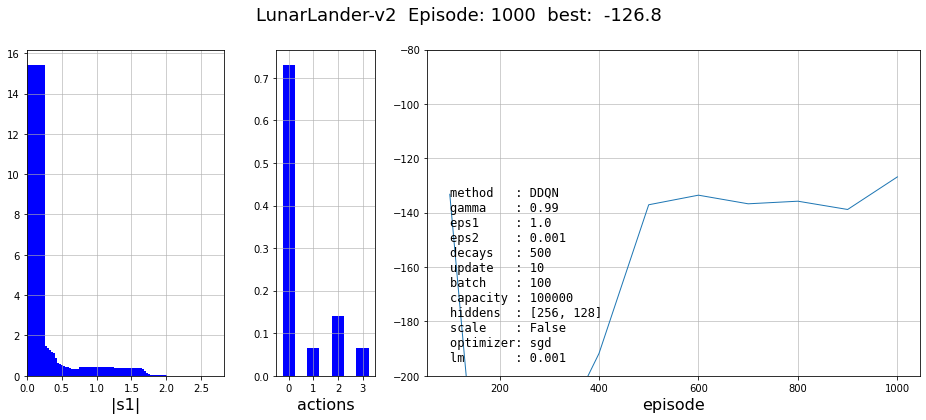

  1100 rew: -134.73 ± 3.71,  best: -126.82,  epsilon: 0.000,  Q:  -81.27 ±   0.000, loss:  7.267, time: 49s
  1200 rew: -123.75 ± 4.90,  best: -123.75,  epsilon: 0.000,  Q:  -80.67 ±   0.000, loss: 11.004, time: 47s
  1300 rew: -134.23 ± 3.84,  best: -123.75,  epsilon: 0.000,  Q:  -79.87 ±   0.000, loss:  7.764, time: 54s
  1400 rew: -135.99 ± 3.98,  best: -123.75,  epsilon: 0.000,  Q:  -79.40 ±   5.338, loss:  7.768, time: 59s
  1500 rew: -134.03 ± 3.40,  best: -123.75,  epsilon: 0.000,  Q:  -79.00 ±   0.981, loss:  8.196, time: 62s
  1600 rew: -141.03 ± 5.31,  best: -123.75,  epsilon: 0.000,  Q:  -78.24 ±   0.570, loss: 17.728, time: 60s
  1700 rew: -129.43 ± 4.39,  best: -123.75,  epsilon: 0.000,  Q:  -77.64 ±   1.204, loss:  3.796, time: 39s
  1800 rew: -127.25 ± 4.55,  best: -123.75,  epsilon: 0.000,  Q:  -77.17 ±   1.586, loss:  4.004, time: 39s
  1900 rew: -126.61 ± 3.97,  best: -123.75,  epsilon: 0.000,  Q:  -76.98 ±   3.399, loss: 18.677, time: 39s
  2000 rew: -126.18 ± 5.01, 

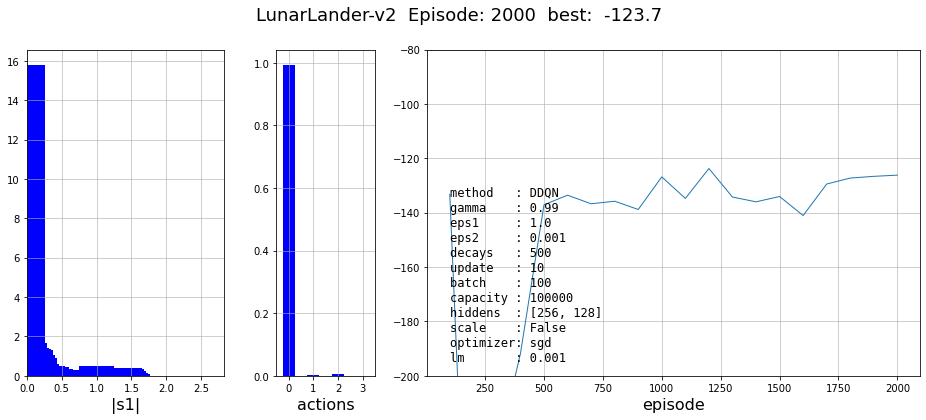

  2100 rew: -132.20 ± 4.35,  best: -123.75,  epsilon: 0.000,  Q:  -76.36 ±   0.000, loss:  0.695, time: 40s
  2200 rew: -134.12 ± 4.02,  best: -123.75,  epsilon: 0.000,  Q:  -76.35 ±   0.000, loss:  9.379, time: 41s
  2300 rew: -131.81 ± 4.64,  best: -123.75,  epsilon: 0.000,  Q:  -76.34 ±   0.000, loss: 12.977, time: 37s
  2400 rew: -130.63 ± 3.99,  best: -123.75,  epsilon: 0.000,  Q:  -76.68 ±   0.000, loss: 17.024, time: 39s
  2500 rew: -132.11 ± 4.12,  best: -123.75,  epsilon: 0.000,  Q:  -76.68 ±   0.000, loss: 24.217, time: 43s
  2600 rew: -131.69 ± 4.54,  best: -123.75,  epsilon: 0.000,  Q:  -75.59 ±   0.000, loss:115.730, time: 39s
  2700 rew: -136.33 ± 3.87,  best: -123.75,  epsilon: 0.000,  Q:  -76.30 ±   0.000, loss: 12.528, time: 39s
  2800 rew: -133.25 ± 3.59,  best: -123.75,  epsilon: 0.000,  Q:  -76.81 ±   0.000, loss: 17.246, time: 39s
  2900 rew: -133.04 ± 4.47,  best: -123.75,  epsilon: 0.000,  Q:  -76.74 ±   0.000, loss: 12.237, time: 38s
  3000 rew: -120.44 ± 4.10, 

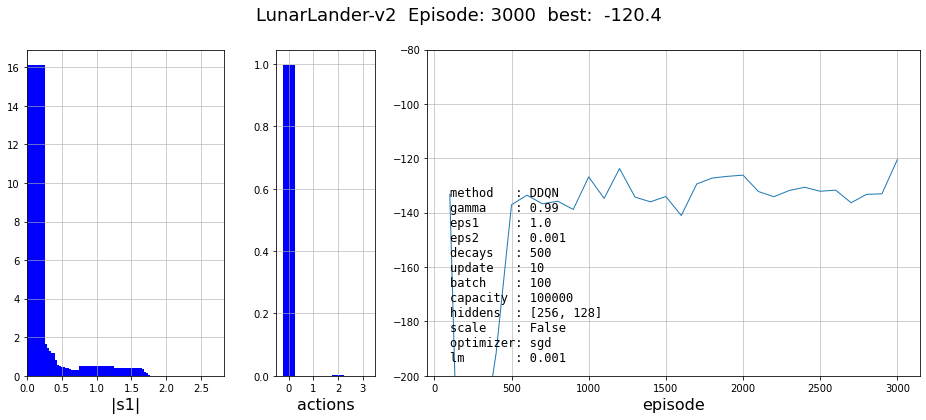

  3100 rew: -132.44 ± 3.27,  best: -120.44,  epsilon: 0.000,  Q:  -76.41 ±   0.000, loss: 11.114, time: 46s
  3200 rew: -136.42 ± 4.54,  best: -120.44,  epsilon: 0.000,  Q:  -77.08 ±   0.000, loss:  2.220, time: 59s
  3300 rew: -137.10 ± 4.44,  best: -120.44,  epsilon: 0.000,  Q:  -77.76 ±   0.000, loss: 11.234, time: 68s
  3400 rew: -133.14 ± 4.12,  best: -120.44,  epsilon: 0.000,  Q:  -78.25 ±   0.000, loss: 12.367, time: 56s
  3500 rew: -135.46 ± 3.56,  best: -120.44,  epsilon: 0.000,  Q:  -78.65 ±   0.000, loss:  2.123, time: 60s
  3600 rew: -131.18 ± 3.79,  best: -120.44,  epsilon: 0.000,  Q:  -78.57 ±   0.000, loss: 11.702, time: 49s
  3700 rew: -135.93 ± 4.30,  best: -120.44,  epsilon: 0.000,  Q:  -78.83 ±   0.000, loss: 12.050, time: 45s
  3800 rew: -128.00 ± 3.32,  best: -120.44,  epsilon: 0.000,  Q:  -79.09 ±   0.000, loss:  5.353, time: 50s
  3900 rew: -135.79 ± 4.32,  best: -120.44,  epsilon: 0.000,  Q:  -79.06 ±   0.000, loss:  6.947, time: 52s
  4000 rew: -131.28 ± 3.78, 

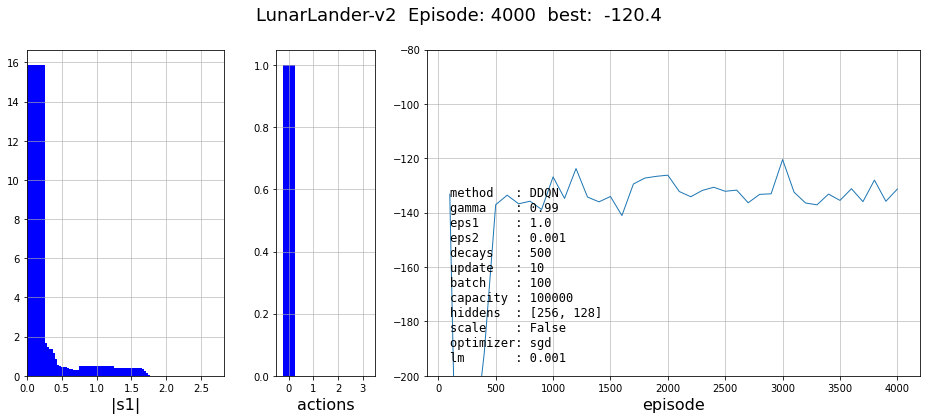

  4100 rew: -133.49 ± 4.83,  best: -120.44,  epsilon: 0.000,  Q:  -78.69 ±   0.000, loss:  8.240, time: 73s
  4200 rew: -118.68 ± 5.36,  best: -118.68,  epsilon: 0.000,  Q:  -78.29 ±   0.000, loss: 88.367, time: 70s
  4300 rew: -130.49 ± 5.53,  best: -118.68,  epsilon: 0.000,  Q:  -78.07 ±   0.000, loss:  6.662, time: 71s
  4400 rew: -139.21 ± 4.51,  best: -118.68,  epsilon: 0.000,  Q:  -78.19 ±   0.000, loss: 15.041, time: 65s
  4500 rew: -134.42 ± 4.33,  best: -118.68,  epsilon: 0.000,  Q:  -78.37 ±   0.000, loss:  1.689, time: 59s
  4600 rew: -134.43 ± 4.54,  best: -118.68,  epsilon: 0.000,  Q:  -78.31 ±   0.000, loss:  6.017, time: 59s
  4700 rew: -137.99 ± 3.49,  best: -118.68,  epsilon: 0.000,  Q:  -78.78 ±   0.000, loss:170.656, time: 67s


KeyboardInterrupt: 

In [45]:
print(dqn.params)
dqn.learn(episodes = 5000, ticks = 200, stat=100, plots = 1000, env_name = env_name)

## Test best model

In [ ]:
dqn.model.load_state_dict( dqn.best_model.state_dict() )
dqn.test(episodes = 1000, ticks=200)

## Save model

In [ ]:
import datetime
  
state = {'info':      "MountainCar: Q-function, Reward:  -97.422 ± 0.2, std: 7, [-108, -83]",     
         'date':      datetime.datetime.now(),  
         'model':     str(dqn.best_model),
         'state' :    dqn.best_model.state_dict(),  
        } 
 
torch.save(state, 'MountainCar_Q_2_256_128_1.97.4.pt')

## Plot policy

In [ ]:
from   matplotlib import colors

bins = (101, 101)   
low  = dqn.obs_min   # minimum observation values
high = dqn.obs_max   # maximum observation values
step = (high-low)/bins

def table(model, bins = (101, 101)):    
    """ Get 2D table of policy function """
    res = np.empty(bins)
    step = (high-low)/bins
    indx = torch.cartesian_prod(torch.arange(0, bins[0]), torch.arange(0, bins[1]))
    gpu  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    X = torch.tensor(low, dtype = torch.float32) + indx*torch.tensor(step, dtype = torch.float32)        
    X = -1. + 2.*(X - low)/(high-low)
    
    with torch.no_grad():
        X = X.to(gpu)
        Y = model.to(gpu)(X).cpu()     
        print(Y.shape)
        Y = torch.argmax(Y, 1).float()
        print(Y.shape)
    
    return Y.view(bins[0], bins[1]).numpy()

def plot(mat, title, d_ticks=1000, bins = (101,101)):
    """ Plot table """
    def index(state):        
        indx = ((state - low)/step).astype(int)
        indx = np.clip(indx, (0,0), (bins[0]-1, bins[1]-1))
        return tuple( indx )

    g, m, x0   = index([0.5, 0.]), index([-math.pi/6, 0.]), np.array([ index([-0.6, 0.]), index([-0.4, 0.]) ])
    cmap = colors.ListedColormap(['blue', 'white', 'red'])    
    
    plt.imshow(mat.T, interpolation='none', origin='lower', cmap= cmap, alpha=0.5)

    plt.title (title, {'fontsize': 16})
    plt.xlabel('x', {'fontsize': 16});         plt.ylabel('v', {'fontsize': 16}) 
    plt.axhline(g[1], c="black", linewidth=1); plt.axvline(g[0], c="black", linewidth=1)
    plt.axvline(m[0], c="black", linewidth=1)
    plt.axvline(x0[0][0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    plt.axvline(x0[1][0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    ticks = range(0, bins[0], d_ticks)
    plt.xticks( ticks, np.round(100*np.linspace(low[0], high[0], len(ticks)))/100 )
    plt.yticks( ticks, np.round(100*np.linspace(low[1], high[1], len(ticks)))/100 )

     
plt.figure(figsize=(10,10))
res = table(dqn.best_model, bins = bins)
print(res.shape, res.min(), res.max(), res.mean())
plot(res, 'Policy function, Reward: -98.1 ± 0.1 in [-107, -83]', d_ticks=100, bins = bins)
plt.show()